# Проект для Викишоп 

**Описание проекта:**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель проекта:**

Создать модель, способную квалифицировать комментарии на позитивные и негативные.

**Задачи проекта:**
1. Обработать и подготовить набор данных для модели
2. Обучить модель на тренировочной выборке 
3. Проверить работу модели на тестовой выборке: результат метрики F1 должен быть не менее 0.75.

**План проекта:**
1. Предварительное ознакомление с данными.
2. Подготовка данных.
3. Подбор модели.

## 1. Предварительное ознакомление с данными.

Скачаем наш датасет и выведем первые строки.

In [1]:
#импортируем необходимые для работы библиотеки

import os
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt


from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from tqdm import tqdm

In [2]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'

if os.path.exists(pth1):
    text = pd.read_csv(pth1)
elif os.path.exists(pth2):
    text = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
text.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Целевой признак хранится в столбце toxic. Во втором столбце text содержится входящий признак - комментарий пользователя. Посмотрим на размер датасета.

In [4]:
text.shape

(159292, 3)

In [5]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Наш датасет содержит 159292 строки и три столбца. пропусков в данных нет. Первый столбец - с нумерацией строк для работы нашей модели будет не нужен, его можно удалить.

In [6]:
text = text.drop(['Unnamed: 0'], axis=1)
text.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Проверим наличие строк-дубликатов.

In [7]:
text.duplicated().sum()

0

Дубликатов в нашем датасете нет, все записи уникальны.

Посмотрим на распределение целевого признака.

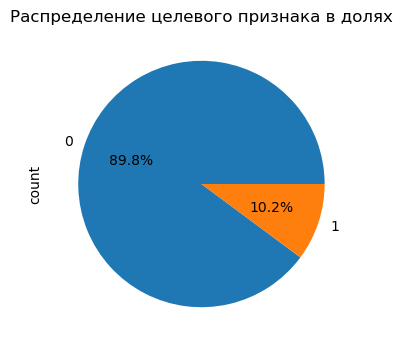

In [8]:
text['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('Распределение целевого признака в долях');

Целевой признак представлен неравномерно, чаще присутствуют отрицательные комментарии, чем положительные. Это нужно будет учесть при обучении модели.

## 2. Подготовка данных

Сначала лемматизируем наш датасет.

In [9]:
# Загрузим список "стоп-слов"
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Роман
[nltk_data]     Полицинский\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
lemmatizer = WordNetLemmatizer()

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Роман
[nltk_data]     Полицинский\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
def get_postag(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

In [14]:
#Создадим функцию для токкенизации и лемматизации текста
def prepare(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = ' '.join(lemmatizer.lemmatize(word.lower(), pos=get_postag(tag)) 
            for word, tag in pos_tag(word_tokenize(text)))
    return text

In [15]:
# Применим функцию к входящим признакам
tqdm.pandas()
corpus = text['text'].progress_apply(lambda x: prepare(x))

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [13:14<00:00, 200.58it/s]


In [16]:
corpus.head()

0    explanation why the edits make under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not try to edit war it s ju...
3    more i can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
Name: text, dtype: object

In [17]:
RANDOM_STATE=11

In [18]:
# Разделим дата сет на тренировочную и тестовую выборки в отношении 80:20
X_train, X_test, y_train, y_test = train_test_split(
corpus,
text['toxic'],
test_size=0.2,
random_state=RANDOM_STATE    
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127433,), (31859,), (127433,), (31859,))

## 3. Подбор модели.

Поиск лучшей модели будем осуществлять через GridSearchCV. Для начала переберем простые модели: логистическую регрессию и дерево решений, затем попробуем мультиномиальную байесовскую модель.

In [19]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
                    ('models', LogisticRegression(random_state=RANDOM_STATE,
                                  solver = 'saga'))]
)

In [20]:
param_grid = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='saga')],
        'models__C': [5, 7, 10, 13, 15],
        'models__penalty': ['l1', 'l2'],
         
    },
{'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
 'models__max_depth': [2,4,6],
 'models__criterion':['gini','entropy']
},
{'models': [MultinomialNB()],
 'models__alpha':[0.01, 0.5, 1]
}
]

In [21]:
    gs = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1')
    
    gs.fit(X_train, y_train)
    print(f'Результат метрики f1 лучшей модели на кросс-валидации', round(gs.best_score_,2))
    print(gs.best_estimator_)


           

Результат метрики f1 лучшей модели на кросс-валидации 0.79
Pipeline(steps=[('vect', TfidfVectorizer()),
                ('models',
                 LogisticRegression(C=5, penalty='l1', random_state=11,
                                    solver='saga'))])


C:\Users\Роман Полицинский\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
result = pd.DataFrame(gs.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(10) 

,rank_test_score,param_models,mean_test_score,params
0,1,"LogisticRegression(random_state=11, solver='sa...",0.789073,"{'models': LogisticRegression(random_state=11,..."
2,2,"LogisticRegression(random_state=11, solver='sa...",0.786226,"{'models': LogisticRegression(random_state=11,..."
5,3,"LogisticRegression(random_state=11, solver='sa...",0.782910,"{'models': LogisticRegression(random_state=11,..."
9,4,"LogisticRegression(random_state=11, solver='sa...",0.782505,"{'models': LogisticRegression(random_state=11,..."
7,5,"LogisticRegression(random_state=11, solver='sa...",0.782250,"{'models': LogisticRegression(random_state=11,..."
4,6,"LogisticRegression(random_state=11, solver='sa...",0.781521,"{'models': LogisticRegression(random_state=11,..."
3,7,"LogisticRegression(random_state=11, solver='sa...",0.780581,"{'models': LogisticRegression(random_state=11,..."
6,8,"LogisticRegression(random_state=11, solver='sa...",0.779619,"{'models': LogisticRegression(random_state=11,..."
8,9,"LogisticRegression(random_state=11, solver='sa...",0.778659,"{'models': LogisticRegression(random_state=11,..."
1,10,"LogisticRegression(random_state=11, solver='sa...",0.777016,"{'models': LogisticRegression(random_state=11,..."


В ходе проверки трех моделей лучшей оказалась модель логистической регресии с гиперпараметрами С=5 и penalty = 'l1' со значением метрики f1 при кросс-валидации 0,79.
Проверим работу лучшей модели на тестовой выборке.

In [23]:
predictions = gs.best_estimator_.predict(X_test)
print(f'Метрика f1 на тестовой выборке составляет {f1_score(y_test, predictions):.2f}')

Метрика f1 на тестовой выборке составляет 0.79


## Вывод:


Целью нашей работы было построение модели, способной определять токсичные комментарии для дальнейшей модерации.
В ходе работы мы провели предварительную обработку данных: данные были лемматизированы и токкенизированы с помощью библиотеки nltk. Проведена векторизация текстов с помощью TfidVectorized. 

Подготовленные данные были поделены на тренировочную и тестовую выборки в отношении 80%-20%. Мы проверили работу трех моделей: логистической регрессии, дерева решений и мультиноминальной байесовской модели. Перебор гиперпараметров моделей делали через GridSearchCV c помощью кросс-валидации. 

В итоге лучшей моделью оказалась модель логистической регрессии с гиперпараметрами C=5, penalty='l1', random_state=11, solver='saga'. Результат метрики f1 этой модели при кросс-валидации составил 0,79.
Проверка модели на тестовых данных дала результат 0,79.
